In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(context="talk", style="ticks", rc=rc)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [14]:
file_path = '附件1 近5年402家供应商的相关数据.xlsx'

order_df = pd.read_excel(file_path, sheet_name='企业的订货量（m³）')
supply_df = pd.read_excel(file_path, sheet_name='供应商的供货量（m³）')

order_df.head()

,供应商ID,材料分类,W001,W002,W003,W004,W005,W006,W007,W008,...,W231,W232,W233,W234,W235,W236,W237,W238,W239,W240
0,S001,B,0,0,0,43,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,S002,A,1,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,0,1
2,S003,C,7,1,0,0,0,1,4,50,...,10,3,50,20,20,7,10,9,20,10
3,S004,B,0,1,1,100,0,85,0,0,...,1,0,1,0,0,0,0,1,0,0
4,S005,A,30,60,60,60,70,70,60,70,...,80,70,70,70,70,70,70,70,70,80


In [7]:
top_50_suppliers = pd .read_excel("TOPSIS前50家供应商.xlsx")
top_50_ids = top_50_suppliers['供应商编号'].head(50).tolist()

# SARIMA

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def predict_supplier_supply_next_24_weeks(supplier_id, supply_df, plot=True):
    row = supply_df[supply_df.iloc[:, 0] == supplier_id]
    if row.empty:
        raise ValueError(f"未在供货量表中找到供应商 {supplier_id}")
    supply_series = row.iloc[0, 2:].astype(float).values
    weeks = pd.date_range(start='2017-01-01', periods=len(supply_series), freq='W')
    supply_ts = pd.Series(supply_series, index=weeks)
    order = (1, 1, 1) 
    seasonal_order = (1, 1, 1, 48)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = SARIMAX(supply_ts, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)

    forecast = results.get_forecast(steps=24)
    predicted_supply = forecast.predicted_mean.values
    predicted_supply = np.where(predicted_supply < 0, 0, predicted_supply).astype(int)
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(supply_ts[-100:], label='历史供货量', marker='o', markersize=3)
        future_index = pd.date_range(start=supply_ts.index[-1], periods=25, freq='W')[1:]
        plt.plot(future_index, forecast.predicted_mean, label='预测供货量', color='r', linestyle='--', marker='x', markersize=4)
        pred_ci = forecast.conf_int()
        plt.fill_between(future_index,
                         pred_ci.iloc[:, 0], pred_ci.iloc[:, 1],
                         color='pink', alpha=0.3, label='95% 置信区间')
        plt.title(f'供应商 {supplier_id} 的供货量预测')
        plt.xlabel('时间')
        plt.ylabel('供货量 ($m^3$)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return predicted_supply

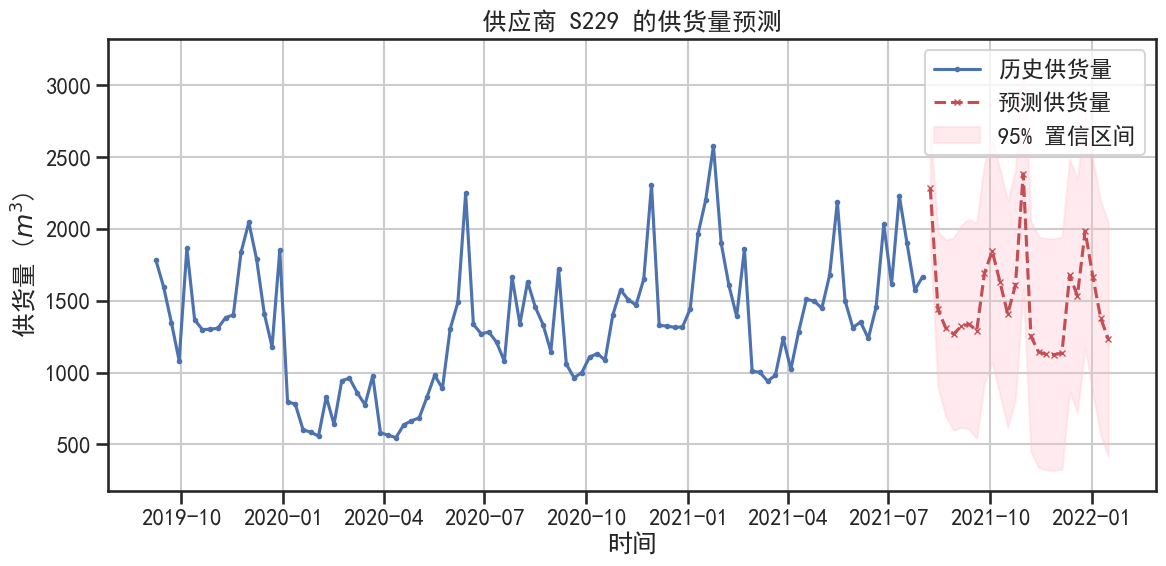

S229未来 24周供货量预测结果： [2285 1439 1309 1267 1321 1336 1291 1691 1844 1630 1406 1609 2382 1251
 1142 1126 1124 1134 1676 1534 1984 1666 1379 1230]


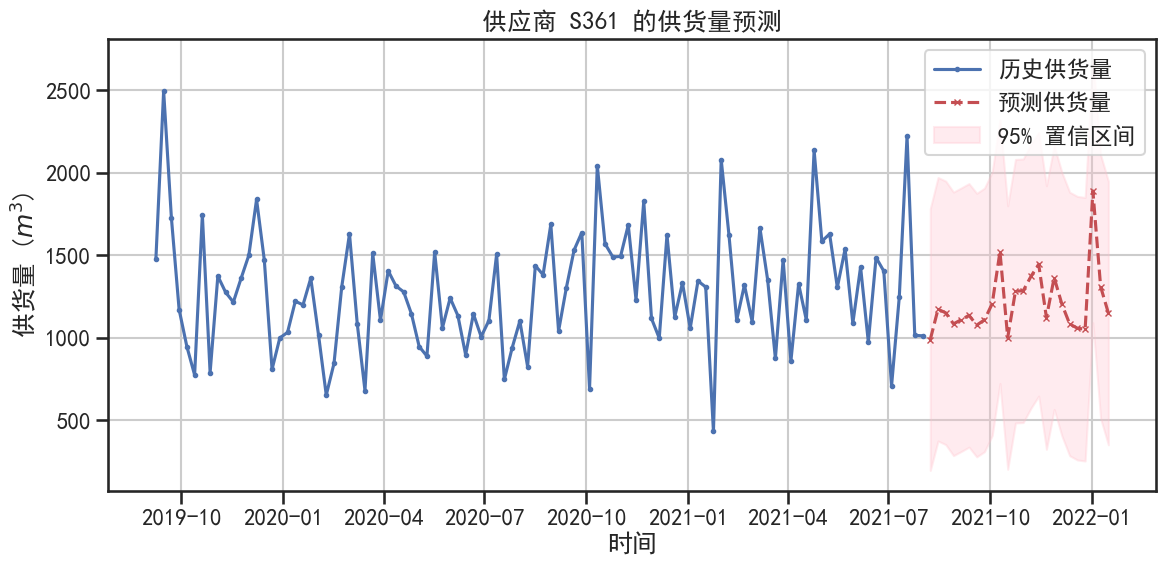

S361未来 24周供货量预测结果： [ 989 1173 1151 1084 1109 1136 1077 1108 1206 1521 1001 1282 1284 1371
 1445 1122 1364 1203 1083 1058 1051 1889 1309 1149]


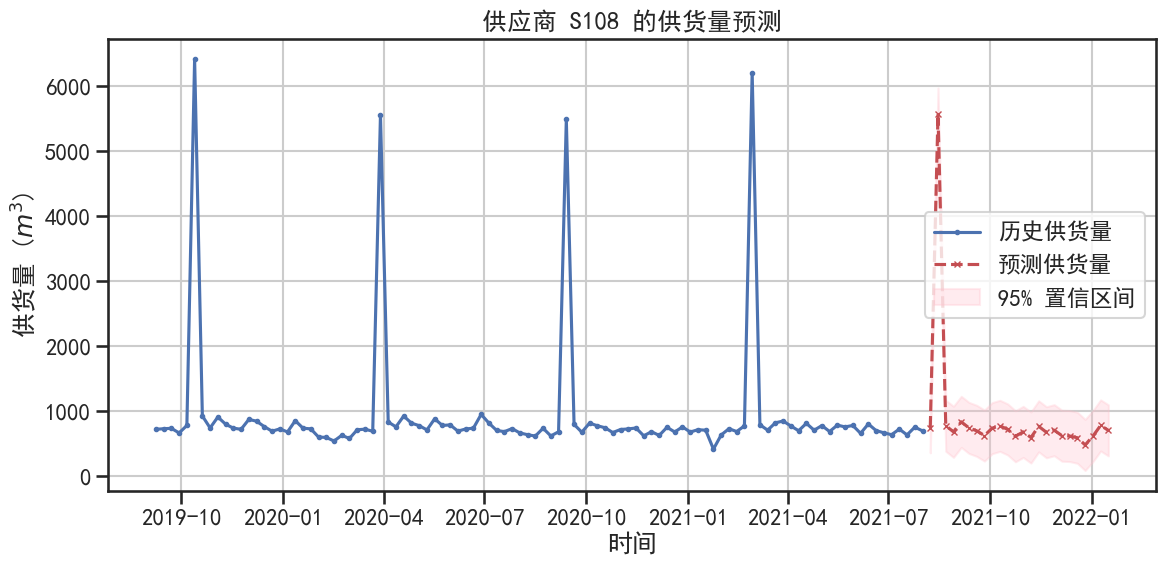

S108未来 24周供货量预测结果： [ 748 5580  776  682  837  743  698  626  740  775  719  614  682  595
  767  676  708  624  618  592  481  616  781  705]


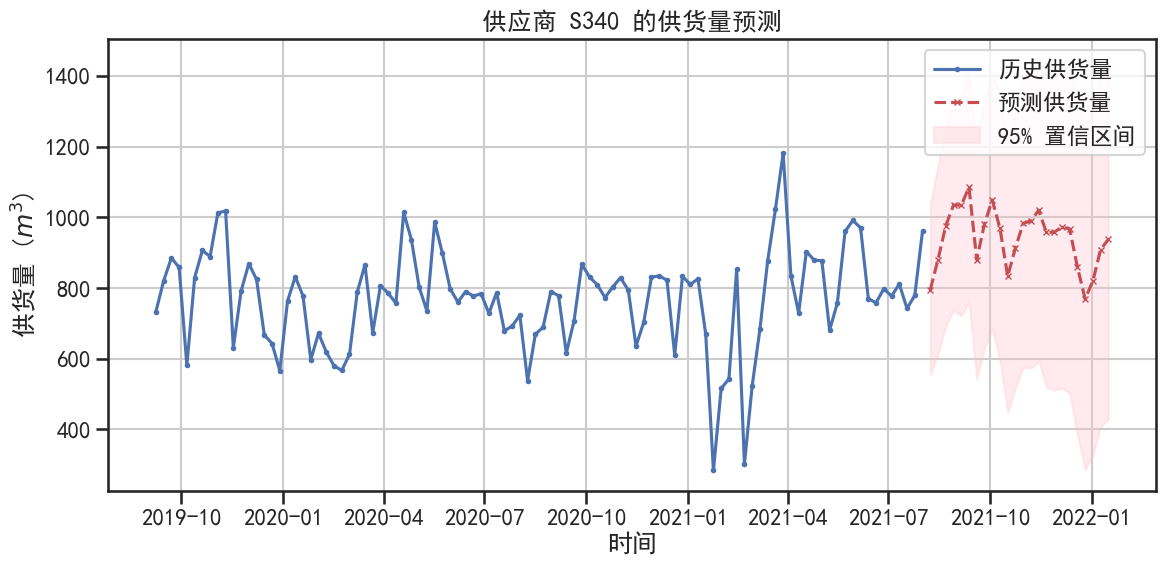

S340未来 24周供货量预测结果： [ 794  880  975 1034 1033 1084  880  981 1048  968  833  913  982  989
 1019  957  957  972  966  859  769  819  908  937]


In [6]:
for i in range(4):
    supplier_id = top_50_ids[i]
    forecast_supply = predict_supplier_supply_next_24_weeks(supplier_id, supply_df)
    print(f"{ supplier_id}未来 24周供货量预测结果：", forecast_supply)

## 预测TOP50供货商的供货量

In [12]:
future_weeks = [f'W{i}' for i in range(241, 265)]  # W241~W264
result_df = pd.DataFrame(columns=['供应商编号', '材料分类'] + future_weeks)

top_50_ids = top_50_suppliers['供应商编号'].tolist()
top_50_supply_sorted = pd.DataFrame()

for supplier_id in top_50_ids:
    match_row = supply_df[supply_df.iloc[:, 0] == supplier_id]
    if not match_row.empty:
        top_50_supply_sorted = pd.concat([top_50_supply_sorted, match_row], ignore_index=True)

for idx in tqdm(range(len(top_50_supply_sorted)), desc="预测供应商供货量"):
    row = top_50_supply_sorted.iloc[idx]
    supplier_id = row.iloc[0]
    category = row.iloc[1]

    try:
        prediction = predict_supplier_supply_next_24_weeks(supplier_id, supply_df,  plot=False)
        new_row = pd.DataFrame([[
            supplier_id,
            category,
            *prediction.tolist()
        ]], columns=result_df.columns)

        result_df = pd.concat([result_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"error: {e}")

预测供应商供货量: 100%|██████████| 50/50 [05:35<00:00,  6.70s/it]


In [13]:
result_df.to_excel("供应商供货量预测结果.xlsx", index=False) # 保存

# SARIMA订货量（ABC）

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_weekly_order_for_category(ts_series, steps=24, order=(1, 1, 1), seasonal_order=(1, 1, 1, 48)):
    model = SARIMAX(ts_series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=steps)
    predicted_mean = forecast.predicted_mean.values
    predicted_mean = np.where(predicted_mean < 0, 0, predicted_mean)  # 替换负值为0
    return forecast.predicted_mean, forecast.conf_int()

In [36]:
warnings.filterwarnings("ignore")
week_columns = [f'W{i:03d}' for i in range(1, 241)]  # ['W001', 'W002', ..., 'W240']
abc_order_data = order_df.groupby('材料分类')[week_columns].sum().loc[['A', 'B', 'C']]
weeks = pd.date_range(start='2017-01-01', periods=240, freq='W')
abc_order_ts = pd.DataFrame({
    'A': abc_order_data.loc['A'].values,
    'B': abc_order_data.loc['B'].values,
    'C': abc_order_data.loc['C'].values
}, index=weeks)

future_weeks = pd.date_range(start=weeks[-1] + pd.Timedelta(days=7), periods=24, freq='W')
predicted_means = {}
conf_ints = {}

for category in ['A', 'B', 'C']:
    mean, ci = predict_weekly_order_for_category(abc_order_ts[category], steps=24)
    predicted_means[category] = mean.values
    conf_ints[category] = ci.values

predicted_df = pd.DataFrame({f'{cat}类预测订货量': predicted_means[cat] for cat in ['A', 'B', 'C']}, index=future_weeks)
new_index = [f"W{i}" for i in range(241, 265)]
predicted_df["Week"] = new_index
print(predicted_df)
predicted_df.to_excel("预测订货量结果.xlsx", index=False)

                 A类预测订货量       B类预测订货量       C类预测订货量  Week
2021-08-08   4658.146579  23632.355345   9691.054561  W241
2021-08-15   4815.123778  11952.676109   9005.842898  W242
2021-08-22   1917.626707  13084.362198   9779.684445  W243
2021-08-29   3953.147482  10808.663645   9597.281450  W244
2021-09-05   2514.106232  21425.357952   8642.340188  W245
2021-09-12   9054.087383   6760.955054   8762.998507  W246
2021-09-19   7019.144571   9241.862500   9220.753600  W247
2021-09-26  14168.890997  11459.136345   9546.202245  W248
2021-10-03   6894.856231  14031.052030   9971.954958  W249
2021-10-10   9542.631174   9268.132918  10728.368956  W250
2021-10-17   4863.380338   6641.451672  12102.029425  W251
2021-10-24   4878.635914   7402.576263  12178.129146  W252
2021-10-31   6633.523936   9982.221067  11647.298666  W253
2021-11-07   7157.215147   5898.435957  11750.085414  W254
2021-11-14   5023.558017   7631.241994  12264.247487  W255
2021-11-21   4450.868655  10826.816257  10993.105558  W2

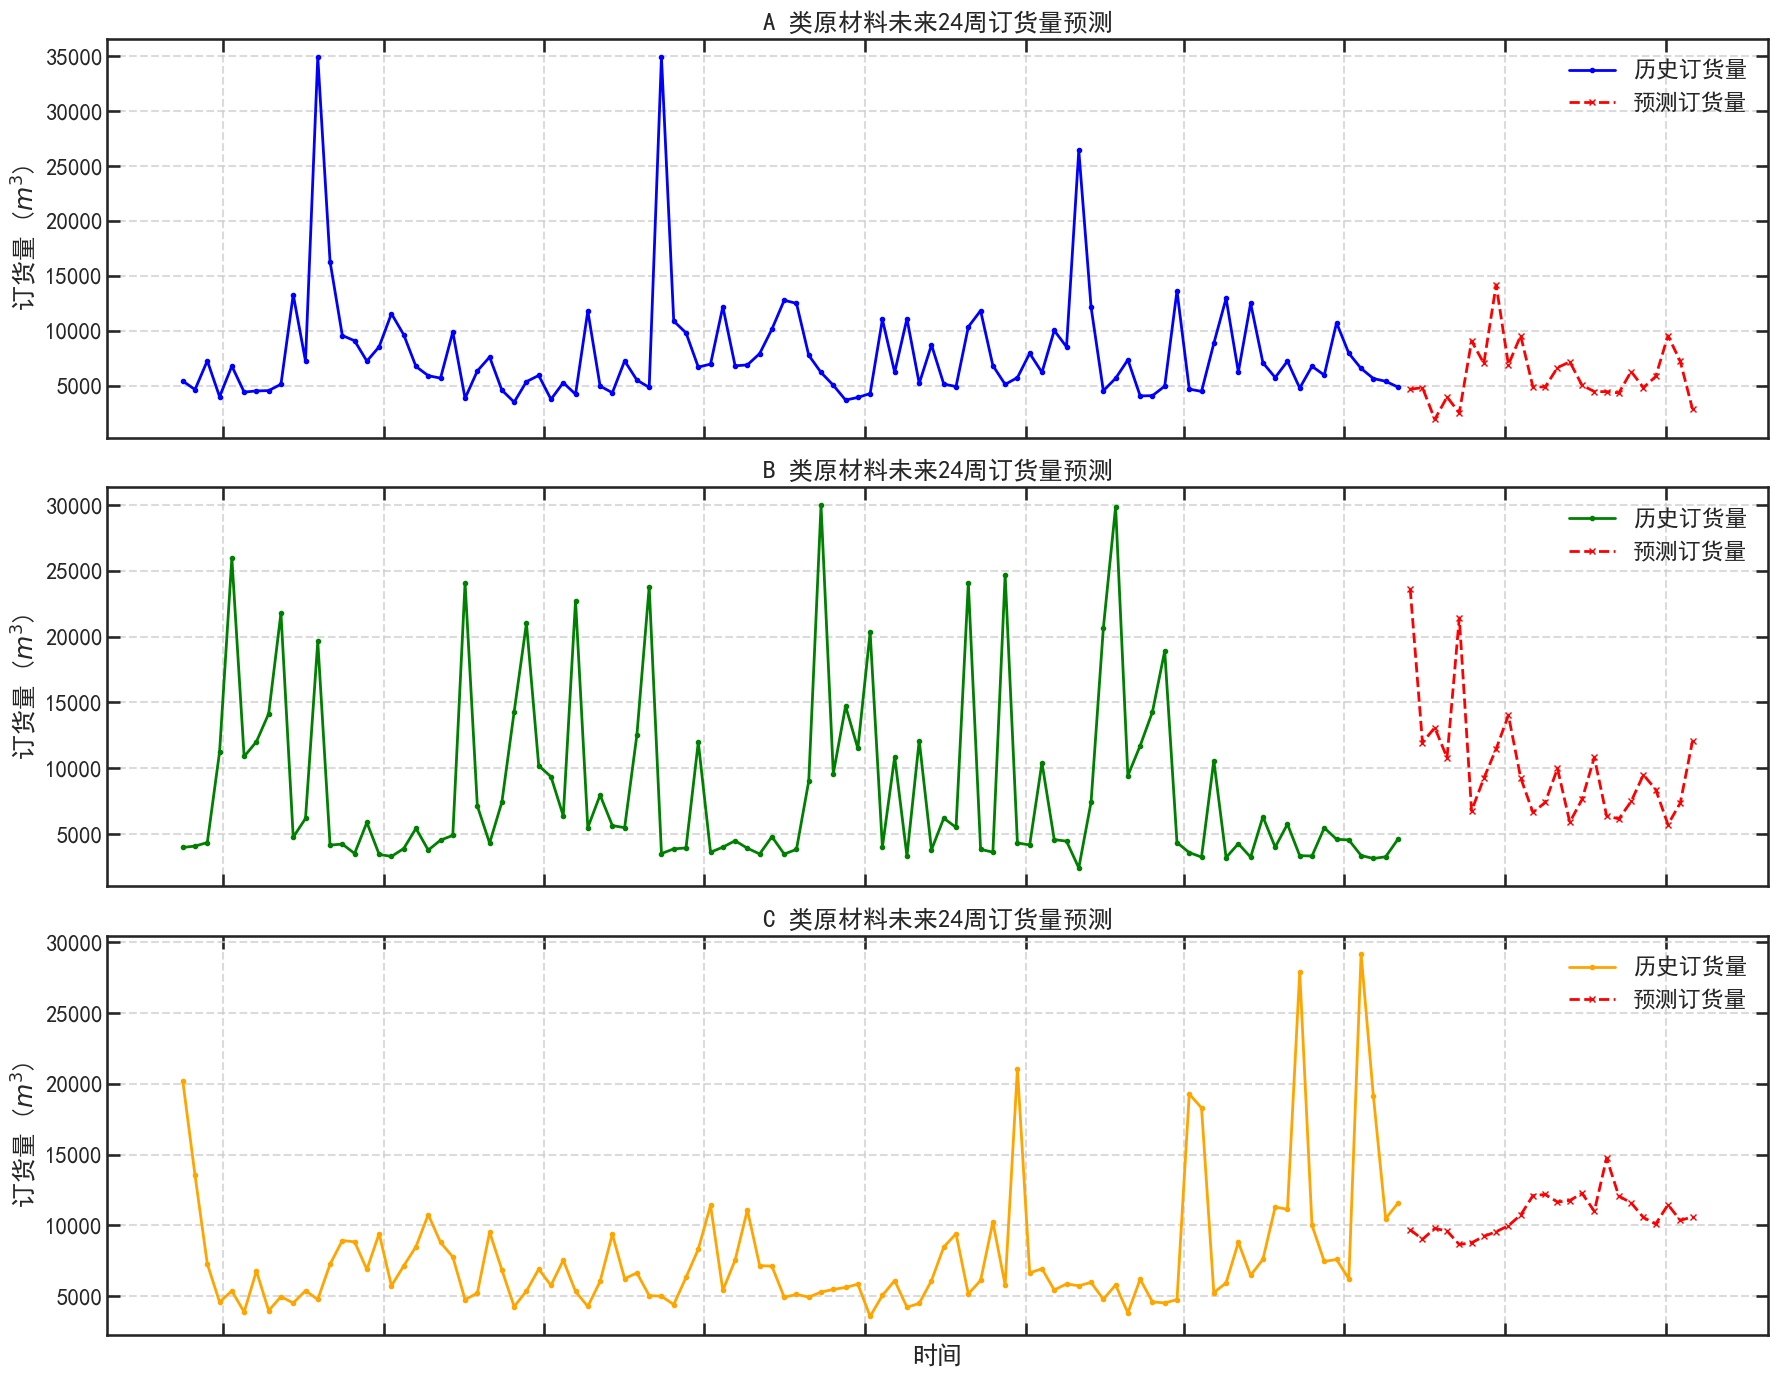

In [22]:
plt.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7
})
fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)
colors = {'A': 'blue', 'B': 'green', 'C': 'orange'}
categories = ['A', 'B', 'C']

for ax, category in zip(axes, categories):
    ax.plot(abc_order_ts.index[-100:], abc_order_ts[category][-100:], label='历史订货量', color=colors[category], marker='o', markersize=3)
    future_index = predicted_df.index
    ax.plot(future_index, predicted_df[f'{category}类预测订货量'], label='预测订货量', color='red', linestyle='--', marker='x', markersize=5)

    ax.set_title(f'{category} 类原材料未来24周订货量预测')
    ax.set_ylabel('订货量 ($m^3$)')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_ticklabels([])

plt.xlabel("时间")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# 平均损耗量曲线

In [40]:
loss_df = pd.read_excel("附件2 近5年8家转运商的相关数据.xlsx")
week_columns = [f'W{i:03d}' for i in range(1, 241)]
loss_data = loss_df[week_columns].values.T
weeks = pd.date_range(start='2017-01-01', periods=240, freq='W')
loss_ts = pd.DataFrame(loss_data, index=weeks, columns=loss_df['转运商ID'])
weekly_avg_loss = loss_ts.mean(axis=1)
avg_loss_series = pd.Series(weekly_avg_loss.values, index=weekly_avg_loss.index)
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_forecast(ts_series, steps=24):
    order = (1, 1, 1)
    seasonal_order = (2, 1, 1, 48)

    model = SARIMAX(ts_series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=steps)

    predicted_mean = forecast.predicted_mean.values
    return predicted_mean


predicted_loss = sarima_forecast(avg_loss_series, steps=24)

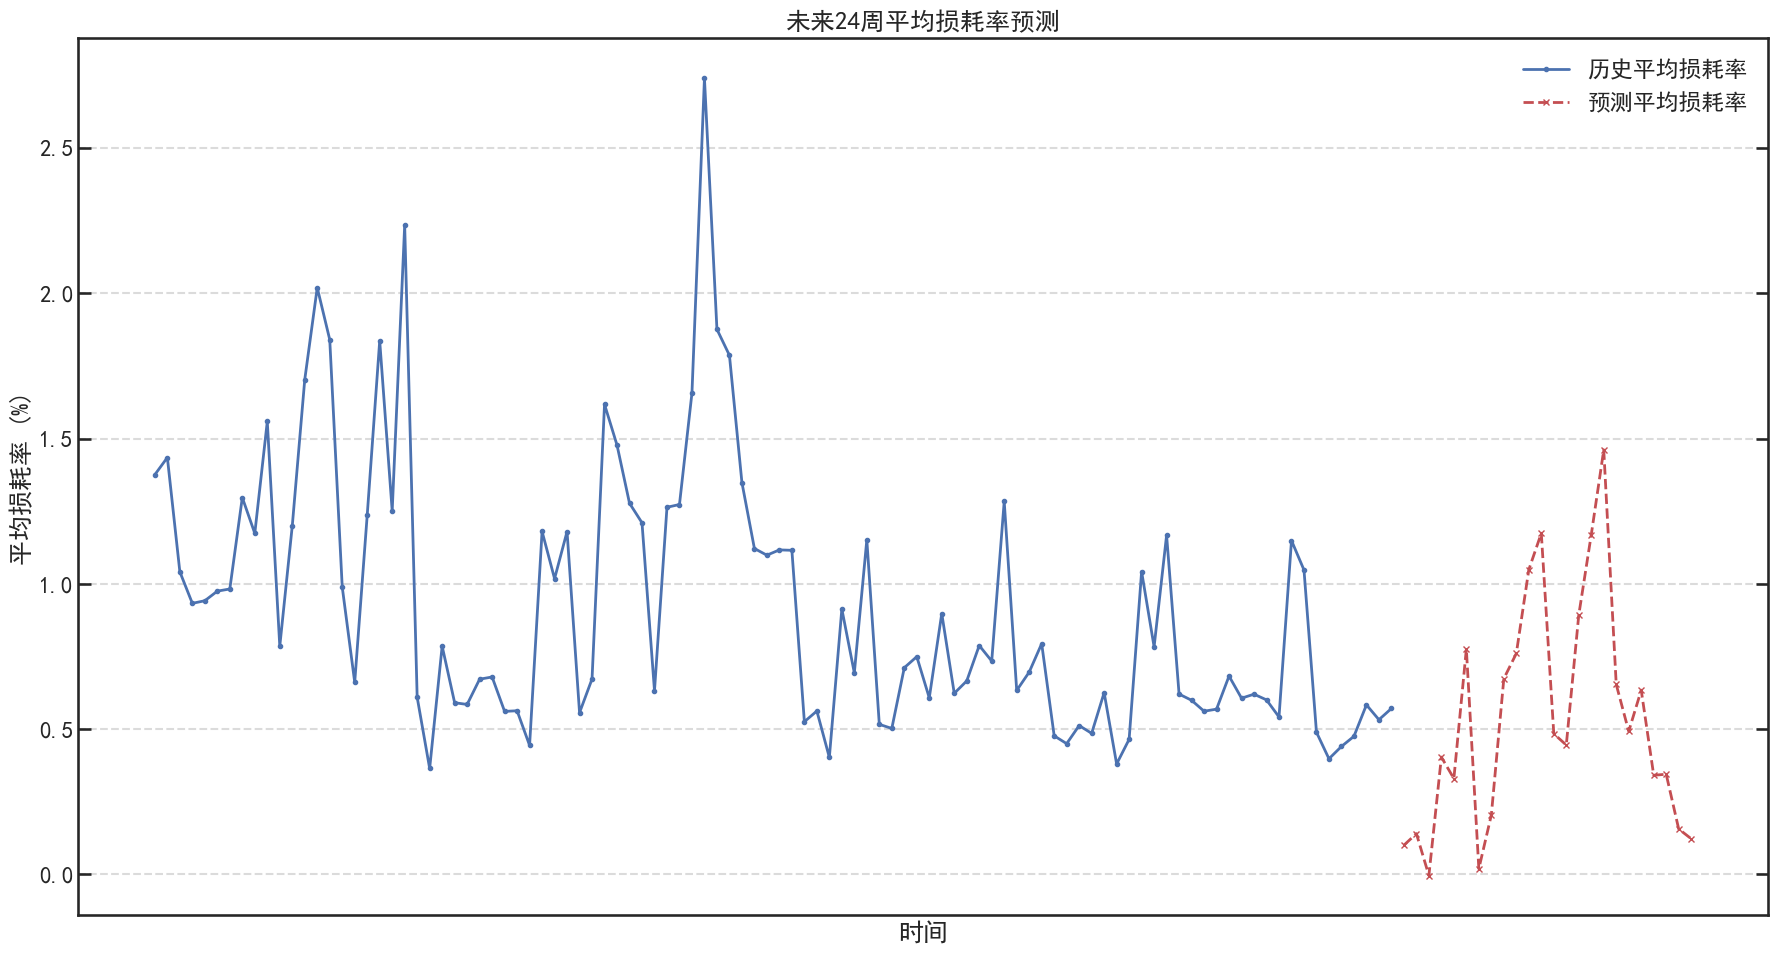

    Week  预测平均损耗率 (%)
0   W241     0.100171
1   W242     0.140154
2   W243    -0.004189
3   W244     0.403555
4   W245     0.329741
5   W246     0.775342
6   W247     0.019227
7   W248     0.204451
8   W249     0.673580
9   W250     0.760287
10  W251     1.048706
11  W252     1.174280
12  W253     0.484042
13  W254     0.444979
14  W255     0.892838
15  W256     1.169234
16  W257     1.461231
17  W258     0.653541
18  W259     0.492309
19  W260     0.634007
20  W261     0.341094
21  W262     0.344470
22  W263     0.156114
23  W264     0.122511


In [42]:
plt.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7
})
plt.figure(figsize=(18, 10))
plt.plot(avg_loss_series[-100:], label='历史平均损耗率', marker='o', markersize=3)
plt.plot(future_index, predicted_loss, label='预测平均损耗率', color='r', linestyle='--', marker='x', markersize=5)

plt.title("未来24周平均损耗率预测")
plt.xlabel("时间")
plt.ylabel("平均损耗率 (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks([])
plt.show()

new_index = [f"W{i}" for i in range(241, 265)]
loss_predicted_df = pd.DataFrame({
    'Week': new_index,
    '预测平均损耗率 (%)': predicted_loss
})
print(loss_predicted_df)

# 遗传算法最优化

In [70]:
df_demand = pd.read_excel("预测订货量结果.xlsx")
demand_A = df_demand["A类预测订货量"].values
demand_B = df_demand["B类预测订货量"].values
demand_C = df_demand["C类预测订货量"].values
loss_rates = loss_predicted_df["预测平均损耗率 (%)"].values
df_suppliers = pd.read_excel("供应商供货量预测结果.xlsx")
supplier_ids = df_suppliers["供应商编号"].tolist()
materials = df_suppliers["材料分类"].tolist()
weeks = [f"W{i}" for i in range(241, 265)]
supply_data = df_suppliers[weeks].values 

In [71]:
def get_supply(individual, week):
    """计算该个体在第 week 周对 A/B/C 的总供货量"""
    supply = {"A": 0, "B": 0, "C": 0}
    selected = [i for i in range(50) if individual[i] == 1]
    for idx in selected:
        mat = materials[idx]
        supply[mat] += supply_data[idx][week]
    return supply

In [77]:
demand_A

array([ 4658.14657874,  4815.1237783 ,  1917.62670742,  3953.14748193,
        2514.10623151,  9054.08738349,  7019.14457132, 14168.89099706,
        6894.85623065,  9542.63117428,  4863.38033796,  4878.6359144 ,
        6633.52393567,  7157.21514725,  5023.55801656,  4450.8686554 ,
        4445.0702023 ,  4330.32540058,  6275.58553218,  4805.02866743,
        5823.1750581 ,  9536.16363462,  7216.84448348,  2853.77804523])

In [79]:
demand_B

array([23632.35534492, 11952.67610934, 13084.3621984 , 10808.66364538,
       21425.3579523 ,  6760.95505444,  9241.86250001, 11459.13634502,
       14031.05203031,  9268.13291827,  6641.45167197,  7402.57626337,
        9982.22106743,  5898.43595703,  7631.24199407, 10826.81625666,
        6384.10259473,  6151.39854109,  7475.57696956,  9503.95437589,
        8380.78031296,  5723.39838891,  7350.2501819 , 12070.35679396])

In [80]:
demand_C

array([ 9691.05456145,  9005.8428978 ,  9779.68444543,  9597.28145   ,
        8642.34018843,  8762.99850729,  9220.75359993,  9546.20224521,
        9971.95495818, 10728.36895601, 12102.02942512, 12178.12914576,
       11647.29866625, 11750.0854138 , 12264.24748719, 10993.10555754,
       14751.32692977, 12059.39806669, 11586.99052778, 10554.86405459,
       10089.87960863, 11455.40907375, 10352.09214999, 10588.51006283])

In [78]:
get_supply(np.ones(50, dtype=int), 0)

{'A': 7443, 'B': 26947, 'C': 8580}

In [84]:
def fitness(individual, week):
    loss = loss_rates[week]
    demand = {
        "A": demand_A[week],
        "B": demand_B[week],
        "C": demand_C[week]
    }

    supply = get_supply(individual, week)
    received_A = supply["A"] * (1 - loss)
    received_B = supply["B"] * (1 - loss)
    received_C = supply["C"] * (1 - loss)

    shortage_penalty = 0
    if received_A < demand["A"]:
        shortage_penalty += (demand["A"] - received_A) ** 2
    if received_B < demand["B"]:
        shortage_penalty += (demand["B"] - received_B) ** 2
    if received_C < demand["C"]:
        shortage_penalty += (demand["C"] - received_C) ** 2

    if shortage_penalty == 0:
        return sum(individual)  # 成本：供应商数量
    else:
        return 1000 + shortage_penalty * 0.1  # 惩罚项替代 inf

In [88]:
def genetic_algorithm(week, pop_size=100, generations=100, mutation_rate=0.05):

    print(f"\n=== 开始处理第 {week+1} 周（{weeks[week]}） ===")

    population = np.random.randint(0, 2, size=(pop_size, 50))

    for gen in range(generations):
        scores = np.array([fitness(ind, week) for ind in population])

        best_idx = np.argmin(scores)
        best_ind = population[best_idx]
        best_score = scores[best_idx]
        if gen % 10 == 0 or gen == generations - 1:
            print(f"Generation {gen}: 最优适应度 = {best_score:.2f}")

        selected_indices = np.argsort(scores)[:int(pop_size * 0.2)]
        parents = population[selected_indices]

        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = parents[np.random.choice(len(parents), 2, replace=False)]
            crossover_point = np.random.randint(1, 49)
            child = np.concatenate((p1[:crossover_point], p2[crossover_point:]))
            offspring.append(child)

        for i in range(len(offspring)):
            if np.random.rand() < mutation_rate:
                idx = np.random.randint(0, 50)
                offspring[i][idx] ^= 1  # 翻转位

        population = np.array(offspring)

    final_scores = np.array([fitness(ind, week) for ind in population])
    best_idx = np.argmin(final_scores)
    best_individual = population[best_idx]
    num_suppliers = sum(best_individual)
    selected_suppliers = [supplier_ids[i] for i in range(50) if best_individual[i] == 1]

    print(f"\n✅ 第 {week+1} 周最优解:")
    print(f"📌 供应商数量: {num_suppliers}")
    print(f"📌 选中的供应商: {selected_suppliers}")

    return {
        "week": weeks[week],
        "num_suppliers": num_suppliers,
        "selected_suppliers": selected_suppliers
    }

In [90]:
a = genetic_algorithm(0)


=== 开始处理第 1 周（W241） ===
Generation 0: 最优适应度 = 1381338.60
Generation 10: 最优适应度 = 438605.70
Generation 20: 最优适应度 = 390406.97
Generation 30: 最优适应度 = 389295.51
Generation 40: 最优适应度 = 389295.51
Generation 50: 最优适应度 = 389295.51
Generation 60: 最优适应度 = 389295.51
Generation 70: 最优适应度 = 389295.51
Generation 80: 最优适应度 = 389295.51
Generation 90: 最优适应度 = 389295.51
Generation 99: 最优适应度 = 389295.51

✅ 第 1 周最优解:
📌 供应商数量: 39
📌 选中的供应商: ['S229', 'S361', 'S108', 'S340', 'S282', 'S329', 'S131', 'S151', 'S330', 'S268', 'S306', 'S356', 'S194', 'S139', 'S352', 'S143', 'S395', 'S037', 'S374', 'S284', 'S247', 'S140', 'S365', 'S338', 'S031', 'S040', 'S364', 'S055', 'S086', 'S367', 'S114', 'S294', 'S080', 'S244', 'S218', 'S074', 'S210', 'S189', 'S078']
